**Linear mixed modeling from DataCamp**

This will serve as some notes for the Hierarchical and Mixed Effect Models in R from DataCamp [link](https://learn.datacamp.com/courses/hierarchical-and-mixed-effects-models). The sections will correspond to the sections in the course.

# Overview and introduction to hierarchical and mixed models

In [1]:
library(tidyverse)
library(WWGbook)   # for data loading
library(lme4)
library(stats)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Course overview:

- Components for mixed-effect models (see how it can be applied to student test scores)
- Applying and interpreting linear mixed-effect models (e.g. regression)
- Generalized linear mixed-effect models
- Repeated measure models (e.g. time-series analysis)

What is a hierarchical model?

- Data can have several types of structure, including being nested within itself, making it "hierarchical". (Example: evaluating whether sitting or standing has an effect on engagement time but whether it's an iPhone or Samsung matters more.)

Why do we use a hierarchical model?

- Data nested within itself.
    - Example: Each student has their own test score but student performance can vary because of classroom-level factors, such as teacher quality, or school-level factors such as building quality. Hence, one might ask "Are students really independent from other students in the same classroom or school?" (Probably not.)
- Pool information across small sample sizes. (What if each classroom has a different number of students?)
    - Example: Maybe 5th grade has 30 students while 3rd grade only has 5. By chance, the 3rd grade test scores are more likely to have high or low outliers because of the law of large numbers. By treating classroomms as a "random-effect" within the model, we can pool shared information about means across the classrooms within the same school.
- Repeated observations across groups or individuals.
    - Example: What if we revisit the same group of students year-after-year? Here, the observations are *not* independent across years. A repeated-measures analysis is another example of a hierarchical models and allows us to correct for this (described in chapter 4).

Other names for hierarchical models

- Hierarchical models: nested models, multi-level models
- Regression framework
    - "Pool" information
    - "Random-effect" versus a "fixed-effect"
    - "Mixed-effect" (linear mixed-effect model; LMM)
    - Linear mixed-effect regression (lmer)
- Repeated sampling: getting the same measurements of individuals or groups over time
    - Repeated measures
    - Paired-tests
    
Example for learning: school test scores

Meta-data:
- Gain in math scores for individual students from K to first grade
- Part of a national-level assessment in US
- Subset of data from West, Welch, and Galecki

Student-level variables:
- Studentid: `childid`
- Math test-score gain: `mathgain`
- Math kindergarten score: `mathdind`
- Student's sex: `sex`
- Student's minority status: `minority`
    
At the end of the chapter, we'll fit a multi-level model to our data. We'll explore the data. The purpose of the coding exercise is to show that linear models don't always produce intuitive results and that it is necessary to add a new technique to your modeling toolbox.

The data contains classroom and school-level data.

Classoom-level variables:
- Classroom id: `classid`
- Teacher's math training: `mathprep`
- Teacher's math test knowledge test score: `mathknow`
- Teacher's years teaching: `yearstea`

School-level variables:
- School id: `schoolid`
- School's household poverty level: `housepov`
- School's socioeconomic status: `ses`



## Exploring data

In [2]:
attach(classroom)

In [3]:
head(classroom)

,sex,minority,mathkind,mathgain,ses,yearstea,mathknow,housepov,mathprep,classid,schoolid,childid
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,1,448,32,0.46,1,NA,0.082,2.00,160,1,1
2,0,1,460,109,-0.27,1,NA,0.082,2.00,160,1,2
3,1,1,511,56,-0.03,1,NA,0.082,2.00,160,1,3
4,0,1,449,83,-0.38,2,-0.11,0.082,3.25,217,1,4
5,0,1,425,53,-0.03,2,-0.11,0.082,3.25,217,1,5
6,1,1,450,65,0.76,2,-0.11,0.082,3.25,217,1,6


### Build a simple (linear) model firstm

Before using a hierarchical model, it's useful to plot and build a simple model. It provides comparison and troubleshooting is simpler with a linear model.

In this exercise, plot and model how math test score gains vary with SES across three levels without ccounting for hierarchical nature of data. Model data at the student level.

In [3]:
# Rename so that the same variables can be used as the DC lesson.
studentData <- classroom

`geom_smooth()` using formula 'y ~ x'




Call:
lm(formula = mathgain ~ housepov, data = studentData)

Residuals:
     Min       1Q   Median       3Q      Max 
-168.226  -22.222   -1.306   19.763  195.156 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   56.937      1.674   34.02   <2e-16 ***
housepov       3.531      7.515    0.47    0.639    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.63 on 1188 degrees of freedom
Multiple R-squared:  0.0001858,	Adjusted R-squared:  -0.0006558 
F-statistic: 0.2208 on 1 and 1188 DF,  p-value: 0.6385


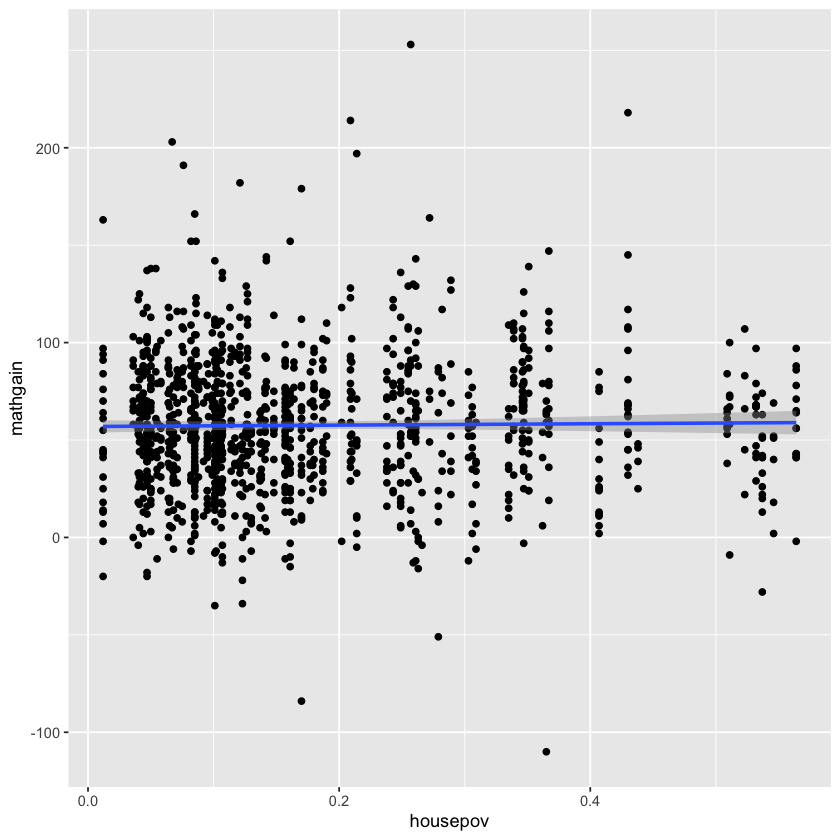

In [4]:
# Plot the data
ggplot(data = studentData, aes(x = housepov, y = mathgain)) +
    geom_point() +
    geom_smooth(method = 'lm')

# Fit a linear model
summary(lm(mathgain ~ housepov , data =  studentData))

### Explore multiple-levels

The simple model above assumed students were independent of each other. However, students learn within classrooms and schools. Aggregating scores by classroom and school can account for lack of student independence. Aggregation methods are important, especially for unequal group sizes.

Here, we'll use summary means for school and classroom. Another method would be to take 2 means (1st student by class, 2nd by class by school).

Aggregated datasets for both class and school are needed.

First build an aggregated classData set from the studentData, using the classid. For each class, take the mean of the students in the class.

In [5]:
head(studentData)

,sex,minority,mathkind,mathgain,ses,yearstea,mathknow,housepov,mathprep,classid,schoolid,childid
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,1,448,32,0.46,1,NA,0.082,2.00,160,1,1
2,0,1,460,109,-0.27,1,NA,0.082,2.00,160,1,2
3,1,1,511,56,-0.03,1,NA,0.082,2.00,160,1,3
4,0,1,449,83,-0.38,2,-0.11,0.082,3.25,217,1,4
5,0,1,425,53,-0.03,2,-0.11,0.082,3.25,217,1,5
6,1,1,450,65,0.76,2,-0.11,0.082,3.25,217,1,6


In [6]:
classData <- studentData %>%
                group_by(classid, schoolid) %>%
                summarize(housepov = mean(housepov, na.rm=T),
                          mathgain = mean(mathgain, na.rm=T))

head(classData)

`summarise()` has grouped output by 'classid'. You can override using the `.groups` argument.



classid,schoolid,housepov,mathgain
<int>,<int>,<dbl>,<dbl>
1,61,0.335,47.80000
2,34,0.303,65.66667
3,56,0.040,15.66667
4,67,0.339,91.50000
5,15,0.121,182.00000
6,21,0.187,39.40000


The, build an aggregated schoolData set from the classData, using the studentid. For each school, take the mean of the classes in the school. 

In [7]:
# schoolData <- classData %>%
#                group_by(schoolid) %>%
#                summarize(housepov = mean(housepov, na.rm=T),
#                          mathgain = mean(mathgain, na.rm=T))

# head(schoolData)

schoolData <- studentData %>%
                group_by(schoolid) %>%
                summarize(housepov = mean(housepov, na.rm=T),
                          mathgain = mean(mathgain, na.rm=T))

head(schoolData)

schoolid,housepov,mathgain
<int>,<dbl>,<dbl>
1,0.082,59.63636
2,0.082,65.00000
3,0.086,88.85714
4,0.365,35.16667
5,0.511,60.16667
6,0.044,78.66667


`geom_smooth()` using formula 'y ~ x'



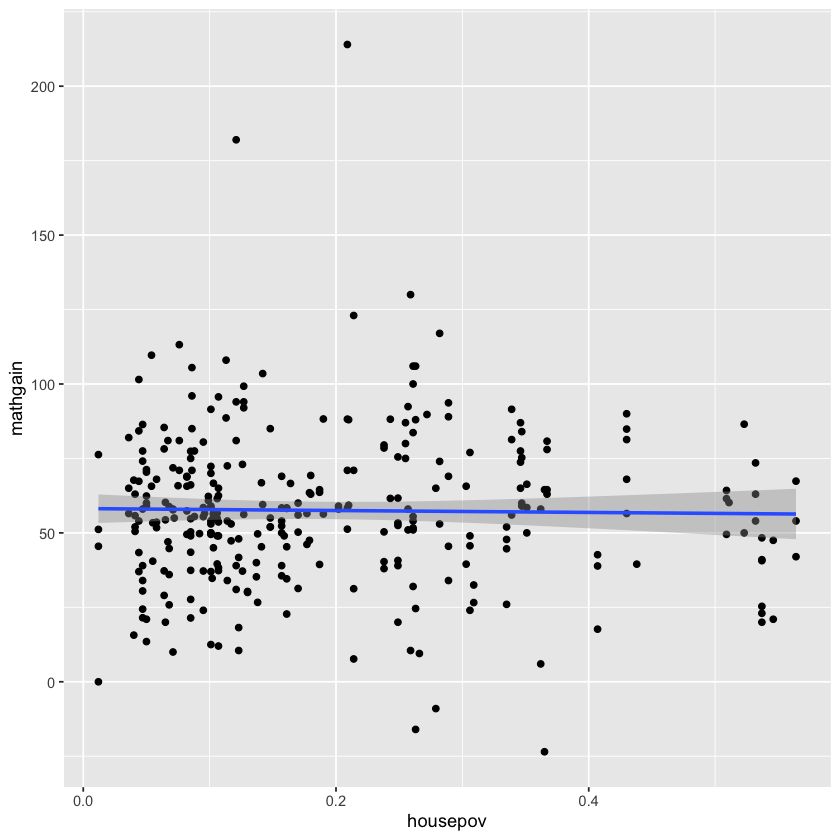

In [8]:
# First, plot the housepov and mathgain at the classroom-level from the classData data.frame
ggplot(data = classData, aes(x = housepov, y = mathgain)) +
    geom_point() +
    geom_smooth(method = 'lm')

`geom_smooth()` using formula 'y ~ x'



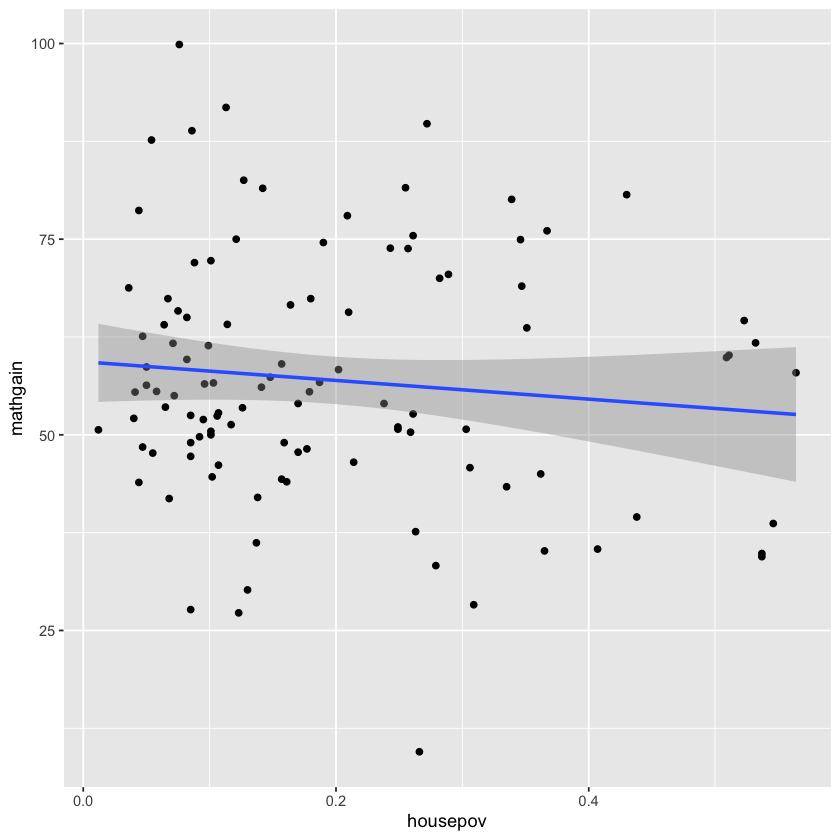

In [9]:
# Second, plot the housepov and mathgain at the school-level from the schoolData data.frame
ggplot(data = schoolData, aes(x = housepov, y = mathgain)) +
    geom_point() +
    geom_smooth(method = 'lm')

Now, compare your linear regression results from the previous expercise to the two new models

In [10]:
summary(lm(mathgain ~ housepov, data = studentData)) ## student-level data
summary(lm(mathgain ~ housepov, data = classData)) ## class-level data
summary(lm(mathgain ~ housepov, data = schoolData)) ## school-level data


Call:
lm(formula = mathgain ~ housepov, data = studentData)

Residuals:
     Min       1Q   Median       3Q      Max 
-168.226  -22.222   -1.306   19.763  195.156 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   56.937      1.674   34.02   <2e-16 ***
housepov       3.531      7.515    0.47    0.639    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.63 on 1188 degrees of freedom
Multiple R-squared:  0.0001858,	Adjusted R-squared:  -0.0006558 
F-statistic: 0.2208 on 1 and 1188 DF,  p-value: 0.6385



Call:
lm(formula = mathgain ~ housepov, data = classData)

Residuals:
    Min      1Q  Median      3Q     Max 
-80.479 -14.444  -1.447  13.151 156.516 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   58.160      2.542  22.879   <2e-16 ***
housepov      -3.236     10.835  -0.299    0.765    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.14 on 310 degrees of freedom
Multiple R-squared:  0.0002876,	Adjusted R-squared:  -0.002937 
F-statistic: 0.08918 on 1 and 310 DF,  p-value: 0.7654



Call:
lm(formula = mathgain ~ housepov, data = schoolData)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.660  -9.947  -2.494   9.546  41.445 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   59.338      2.624  22.616   <2e-16 ***
housepov     -11.948     10.987  -1.087    0.279    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.8 on 105 degrees of freedom
Multiple R-squared:  0.01114,	Adjusted R-squared:  0.00172 
F-statistic: 1.183 on 1 and 105 DF,  p-value: 0.2793


**The significance for association between `mathgain` and `housepov` looks higher the more the data is aggregated.**

Although none of the estimates differs significantly from zero, *arbitrary* data aggregation can be avoided using hierarchical models.

## Parts of a regression

Reviewing basics of linear regression. Models can be shown different ways.

$y = \beta_0 + \beta_2x_2 + \beta_3x_3 + \epsilon$  (one group serves as reference)
<br>
$y = \beta_1 + \beta_2x_2 + \beta_3x_3 + \epsilon$  (means for each determined separately, also this is ANOVA))

In R:

`lm(formula, data)`
<br>
`lm(y ~ x, data = myData)`
<br>
`anova(lm(y ~ x, data = myData))`

This is how linear rmodels are built for *discrete* predictor variables.

*Continuous* predictor variables are similar (slopes).

$y$ ~ $\beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \epsilon$ 

Multiple regression caveats:
- Assumes independence of predictor variables. Deviations can be bad.
- Previous statements, means you need to say "Corrected for"...
- Simpson's paradox can be bad if you're missing some groups
- Only linear relationships
- Interactions may be important

Multiple regression in R tips. Needs some formatting for syntax.
Also, when plotting a regression line in a scatter plot, use `geom_abline`, extracting the intercept and slope instead of `geom_smooth`. It will translate well to later implementations.
